In [2]:
import pandas as pd
import numpy as np
import warnings
import time

import matplotlib.pyplot as plt
from sklearn.metrics import mean_absolute_error, mean_squared_error
from sktime.performance_metrics.forecasting import mean_absolute_scaled_error
from sklearn.model_selection import ParameterGrid

import prophet

warnings.filterwarnings('ignore')

In [3]:
# suppress the prophet logs
import logging

class SuppressFilter(logging.Filter):
    def filter(self, record):
        return False  

logger = logging.getLogger('cmdstanpy')
logger.addFilter(SuppressFilter())

# Prophet Univariate

In [5]:
# read datasets 
enc = pd.read_csv('../../data/regional_datasets/univariate/enc_data_univ.csv')
esc = pd.read_csv('../../data/regional_datasets/univariate/esc_data_univ.csv')
mid_atlantic = pd.read_csv('../../data/regional_datasets/univariate/mid_atlantic_data_univ.csv')
mountain = pd.read_csv('../../data/regional_datasets/univariate/mountain_data_univ.csv')
new_england = pd.read_csv('../../data/regional_datasets/univariate/new_england_data_univ.csv')
pacific = pd.read_csv('../../data/regional_datasets/univariate/pacific_data_univ.csv')
south_atlantic = pd.read_csv('../../data/regional_datasets/univariate/south_atlantic_data_univ.csv')
wnc = pd.read_csv('../../data/regional_datasets/univariate/wnc_data_univ.csv')
wsc = pd.read_csv('../../data/regional_datasets/univariate/wsc_data_univ.csv')
datasets = [enc, esc, mid_atlantic, mountain, new_england, pacific, south_atlantic, wnc, wsc]
for df in datasets:
    df['date'] = pd.to_datetime(df['date'])
    df.drop(columns=["Unnamed: 0"], axis=1, inplace=True)
    df.sort_index(inplace=True)


In [6]:
def baseline_prophet(df, plot=False):
    region = df["region"].iloc[0]
    print(f"Training model for {region}...")

    subset = df[['date', 'new_confirmed']].rename(columns={'date': 'ds', 'new_confirmed': 'y'})

    size = round(df.shape[0]*0.15)
    train = subset.iloc[:-size]
    test = subset.iloc[-size:]
    test_y = test['y']

    model = prophet.Prophet()
    model = model.fit(train)

    # pred, conf_int = model.predict(n_periods=size, return_conf_int=True)
    pred = model.predict(test)
    pred_yhat = pred['yhat']

    # calculate metrics
    mae = mean_absolute_error(test_y, pred_yhat)
    mse = mean_squared_error(test_y, pred_yhat)
    rmse = mean_squared_error(test_y, pred_yhat, squared=False)
    mase = mean_absolute_scaled_error(test_y, pred_yhat, y_train=train['y'])

    print(f'MAE: {round(mae, 2)}')
    print(f'MSE: {round(mse, 2)}')
    print(f'RMSE: {round(rmse, 2)}')
    print(f'MASE: {round(mase, 2)}')

    # plot predictions
    if plot:
        plt.figure(figsize=(15, 5))
        plt.title(f'Univariate Prophet Predictions for {region}')
        plt.plot(test['ds'], test_y, label='True')
        plt.plot(pred['ds'], pred_yhat, label='Predicted')
        # uncomment to show confidence interval
        # plt.fill_between(test.index, conf_int[:, 0], conf_int[:, 1], color='orange', alpha=0.2, label='Confidence Interval')
        plt.legend() 
        plt.show()

22:01:18 - cmdstanpy - INFO - Chain [1] start processing
22:01:18 - cmdstanpy - INFO - Chain [1] done processing


Training model for East North Central...
MAE: 9058.53
MSE: 114291164.1
RMSE: 10690.7
MASE: 1.14


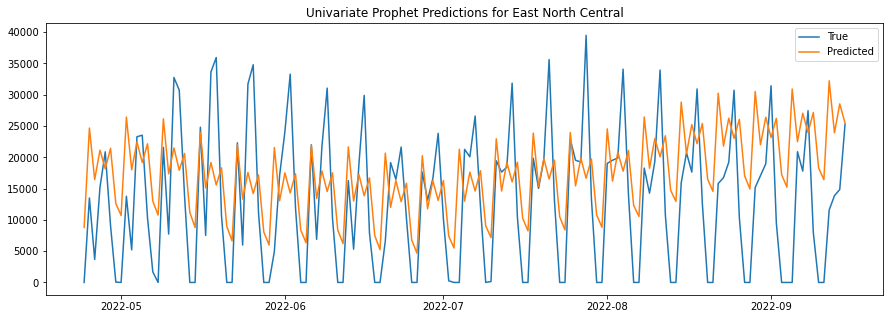

22:01:18 - cmdstanpy - INFO - Chain [1] start processing
22:01:18 - cmdstanpy - INFO - Chain [1] done processing



Training model for East South Central...
MAE: 5932.23
MSE: 51221211.29
RMSE: 7156.9
MASE: 1.79


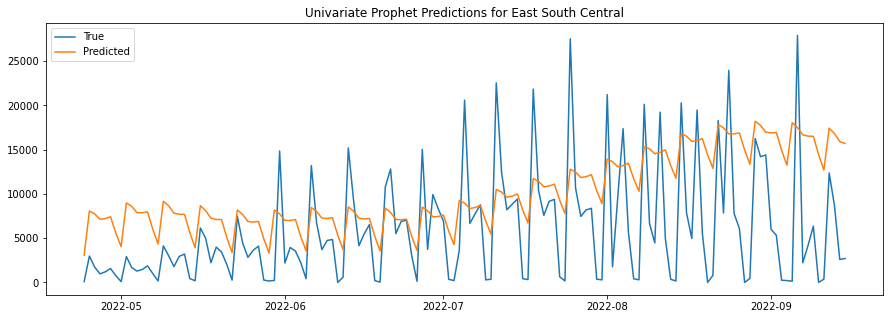

22:01:19 - cmdstanpy - INFO - Chain [1] start processing
22:01:19 - cmdstanpy - INFO - Chain [1] done processing



Training model for Mid-Atlantic...
MAE: 13576.27
MSE: 239715800.11
RMSE: 15482.76
MASE: 6.4


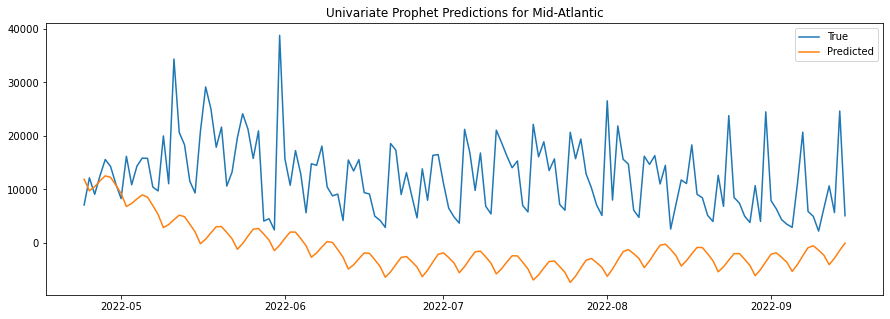

22:01:19 - cmdstanpy - INFO - Chain [1] start processing
22:01:19 - cmdstanpy - INFO - Chain [1] done processing



Training model for Mountain...
MAE: 6831.4
MSE: 65329901.72
RMSE: 8082.69
MASE: 2.16


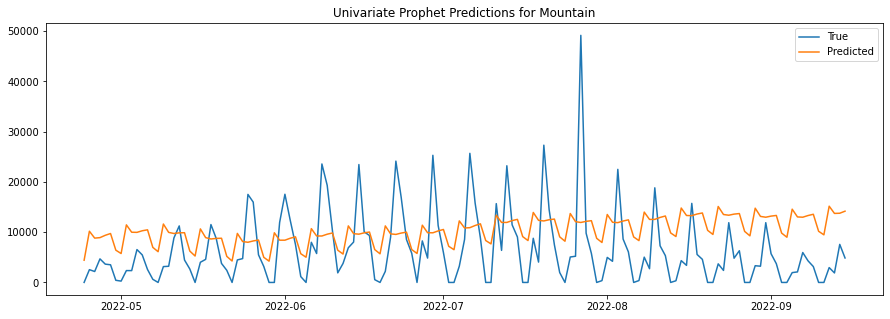

22:01:19 - cmdstanpy - INFO - Chain [1] start processing
22:01:19 - cmdstanpy - INFO - Chain [1] done processing



Training model for New England...
MAE: 3465.13
MSE: 18336728.39
RMSE: 4282.14
MASE: 1.39


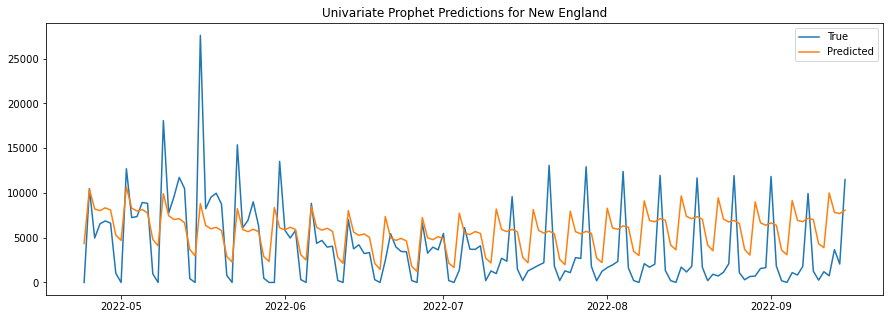

22:01:20 - cmdstanpy - INFO - Chain [1] start processing
22:01:20 - cmdstanpy - INFO - Chain [1] done processing



Training model for Pacific...
MAE: 17486.17
MSE: 412460166.59
RMSE: 20309.12
MASE: 2.61


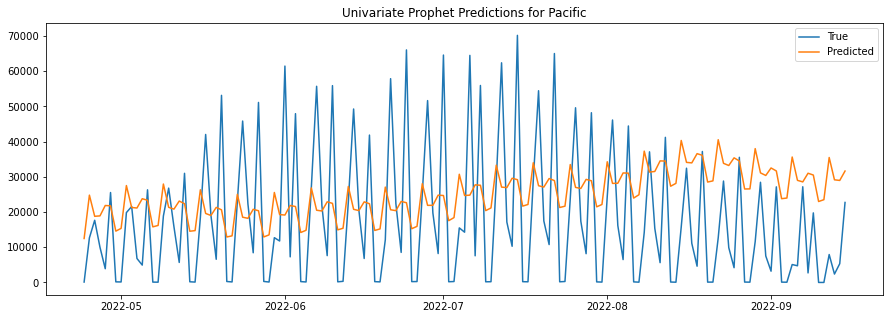

22:01:20 - cmdstanpy - INFO - Chain [1] start processing
22:01:20 - cmdstanpy - INFO - Chain [1] done processing



Training model for South Atlantic...
MAE: 19717.45
MSE: 552964686.03
RMSE: 23515.2
MASE: 1.89


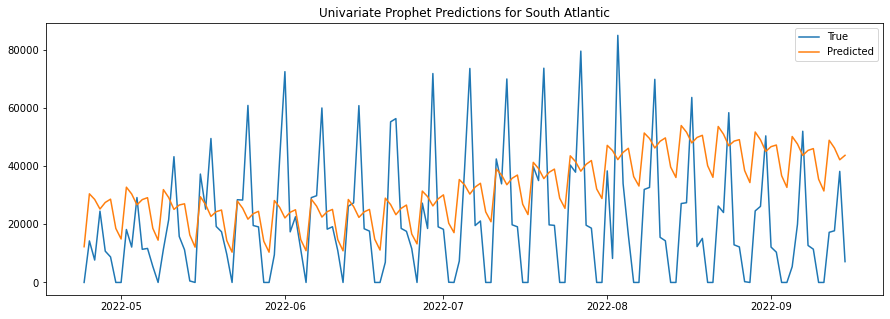

22:01:20 - cmdstanpy - INFO - Chain [1] start processing



Training model for West North Central...


22:01:20 - cmdstanpy - INFO - Chain [1] done processing


MAE: 4146.91
MSE: 24078444.75
RMSE: 4906.98
MASE: 1.33


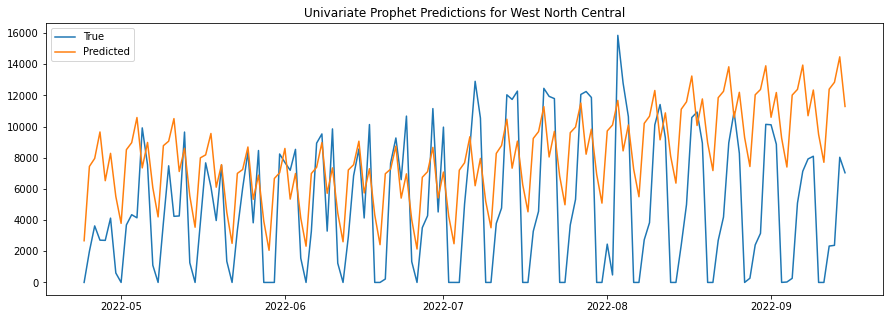

22:01:21 - cmdstanpy - INFO - Chain [1] start processing



Training model for West South Central...


22:01:21 - cmdstanpy - INFO - Chain [1] done processing


MAE: 7473.02
MSE: 95344691.81
RMSE: 9764.46
MASE: 1.69


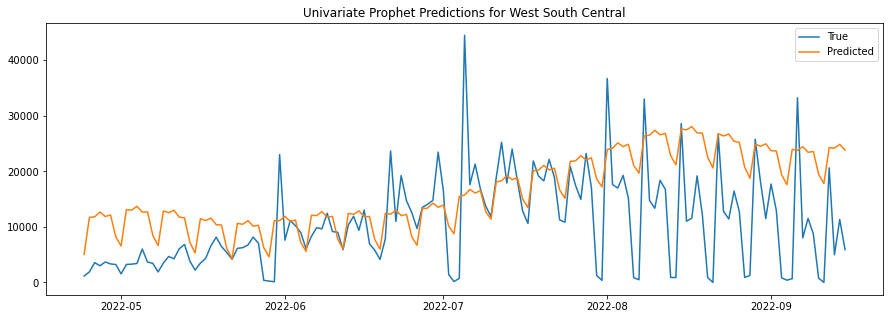


--- 2.96 seconds ---


In [52]:
start_time = time.time()
for df in datasets:
    baseline_prophet(df, plot=True)
    print("")
print(f"--- {round(time.time() - start_time, 2)} seconds ---")

## Parameter Tune

In [66]:
params_grid = {'changepoint_prior_scale':[0.001,0.005,0.01,0.025, 0.05, 0.1],
              'seasonality_prior_scale':[0.1,0.25,0.5,1,2,5]}
grid = ParameterGrid(params_grid)
def optimize_parameters(df):
    region = df["region"].iloc[0]
    print(f"Training model for {region}...")

    subset = df[['date', 'new_confirmed']].rename(columns={'date': 'ds', 'new_confirmed': 'y'})

    size = round(df.shape[0]*0.15)
    train = subset.iloc[:-size]
    test = subset.iloc[-size:]
    test_y = test['y']

    results = []
    for params in grid:

        model = prophet.Prophet(**params)
        model = model.fit(train)

        # pred, conf_int = model.predict(n_periods=size, return_conf_int=True)
        pred = model.predict(test)
        pred_yhat = pred['yhat']

        # calculate metrics
        mae = mean_absolute_error(test_y, pred_yhat)
        rmse = mean_squared_error(test_y, pred_yhat, squared=False)
        mase = mean_absolute_scaled_error(test_y, pred_yhat, y_train=train['y'])

        results.append([params["changepoint_prior_scale"], params["seasonality_prior_scale"], mae, rmse, mase])
                
    results = pd.DataFrame(results, columns=["changepoint_prior_scale", "seasonality_prior_scale", "mae", "rmse", "mase"])
    results.sort_values(by="mase", inplace=True)
    print(results.head())


In [71]:
start_time = time.time()
for df in datasets:
    optimize_parameters(df)
    print("")
print(f"--- {round(time.time() - start_time, 2)} seconds ---")

Training model for East North Central...
   changepoint_prior_scale  seasonality_prior_scale          mae         rmse  \
1                    0.001                     0.25  7571.590973  9823.395935   
0                    0.001                     0.10  7575.735271  9818.216782   
5                    0.001                     5.00  7694.550787  9837.044247   
4                    0.001                     2.00  7695.430570  9837.163021   
2                    0.001                     0.50  7719.988747  9840.740954   

       mase  
1  0.954987  
0  0.955510  
5  0.970496  
4  0.970607  
2  0.973704  

Training model for East South Central...
   changepoint_prior_scale  seasonality_prior_scale          mae         rmse  \
2                    0.001                     0.50  5047.577956  6507.132140   
0                    0.001                     0.10  5059.144564  6514.509222   
1                    0.001                     0.25  5071.066836  6531.760012   
5                    0

In [1]:
parameters = {
    "East North Central": {"changepoint_prior_scale": 0.001, "seasonality_prior_scale": 0.25},
    "East South Central": {"changepoint_prior_scale": 0.001, "seasonality_prior_scale": 0.50},
    "Mid-Atlantic": {"changepoint_prior_scale": 0.005, "seasonality_prior_scale": 0.10},
    "Mountain": {"changepoint_prior_scale": 0.100, "seasonality_prior_scale": 1.0},
    "New England": {"changepoint_prior_scale": 0.001, "seasonality_prior_scale": 5.00},
    "Pacific": {"changepoint_prior_scale": 0.1, "seasonality_prior_scale": 5.00},
    "South Atlantic": {"changepoint_prior_scale": 0.1, "seasonality_prior_scale": 2.00},
    "West North Central": {"changepoint_prior_scale": 0.001, "seasonality_prior_scale": 0.1},
    "West South Central": {"changepoint_prior_scale": 0.050, "seasonality_prior_scale": 0.50}

}

In [8]:
def build_prophet(df, params=None, plot=False):
    region = df["region"].iloc[0]
    print(f"Training model for {region}...")

    subset = df[['date', 'new_confirmed']].rename(columns={'date': 'ds', 'new_confirmed': 'y'})

    size = round(df.shape[0]*0.15)
    train = subset.iloc[:-size]
    test = subset.iloc[-size:]
    test_y = test['y']

    if params:
        model = prophet.Prophet(**params)
    else:
        model = prophet.Prophet()
    model = model.fit(train)

    # pred, conf_int = model.predict(n_periods=size, return_conf_int=True)
    pred = model.predict(test)
    pred_yhat = pred['yhat']

    # calculate metrics
    mae = mean_absolute_error(test_y, pred_yhat)
    mse = mean_squared_error(test_y, pred_yhat)
    rmse = mean_squared_error(test_y, pred_yhat, squared=False)
    mase = mean_absolute_scaled_error(test_y, pred_yhat, y_train=train['y'])

    print(f'MAE: {round(mae, 2)}')
    print(f'MSE: {round(mse, 2)}')
    print(f'RMSE: {round(rmse, 2)}')
    print(f'MASE: {round(mase, 2)}')

    # plot predictions
    if plot:
        plt.figure(figsize=(15, 5))
        plt.title(f'Univariate Prophet Predictions for {region}')
        plt.plot(test['ds'], test_y, label='True')
        plt.plot(pred['ds'], pred_yhat, label='Predicted')
        # uncomment to show confidence interval
        # plt.fill_between(test.index, conf_int[:, 0], conf_int[:, 1], color='orange', alpha=0.2, label='Confidence Interval')
        plt.legend() 
        plt.show()

Training model for East North Central...
MAE: 7571.59
MSE: 96499107.69
RMSE: 9823.4
MASE: 0.95


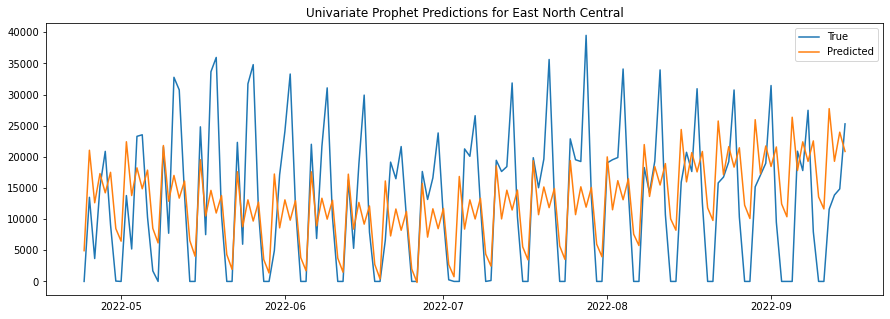


Training model for East South Central...
MAE: 5047.58
MSE: 42342768.69
RMSE: 6507.13
MASE: 1.52


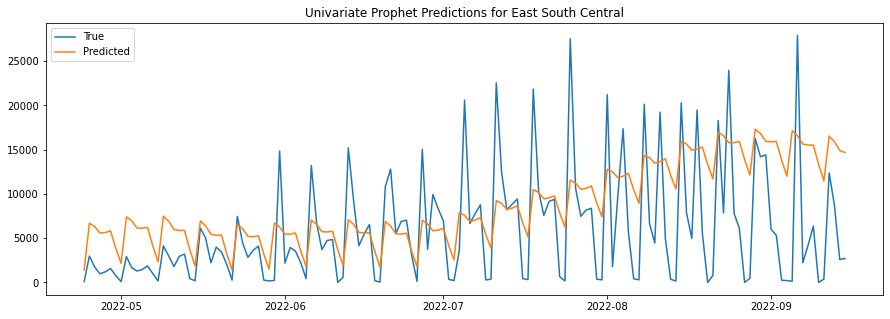


Training model for Mid-Atlantic...
MAE: 6184.42
MSE: 57455959.61
RMSE: 7579.97
MASE: 2.91


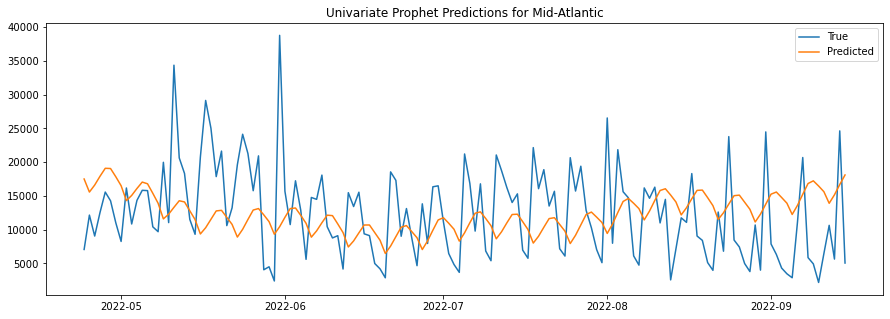


Training model for Mountain...
MAE: 4962.46
MSE: 67765836.5
RMSE: 8232.0
MASE: 1.57


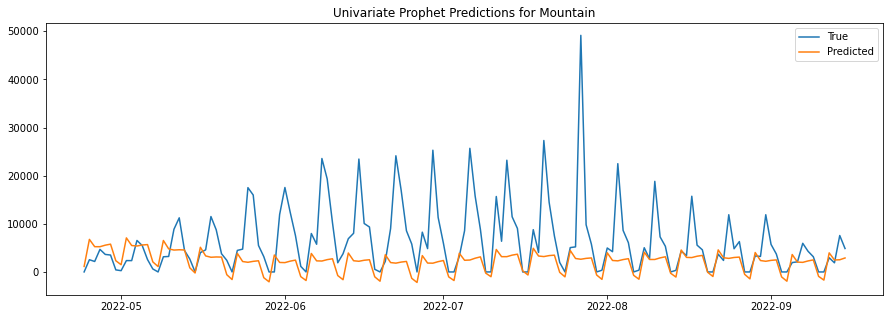


Training model for New England...
MAE: 2718.12
MSE: 15293750.47
RMSE: 3910.72
MASE: 1.09


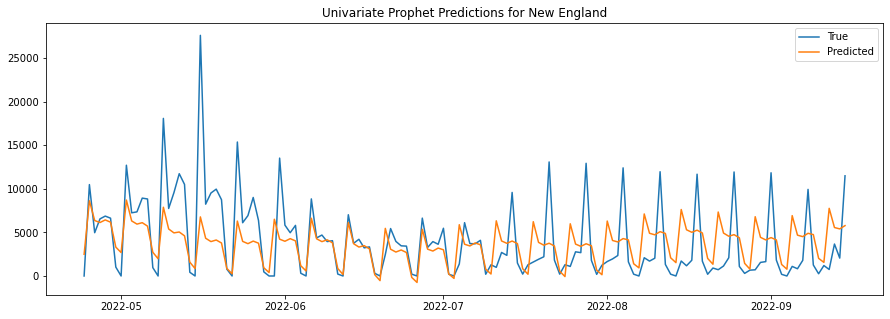


Training model for Pacific...
MAE: 13071.93
MSE: 433159424.37
RMSE: 20812.48
MASE: 1.95


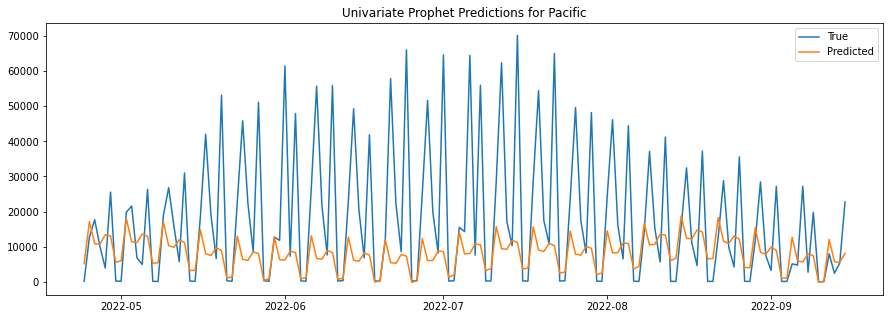


Training model for South Atlantic...
MAE: 15595.21
MSE: 527213493.5
RMSE: 22961.13
MASE: 1.5


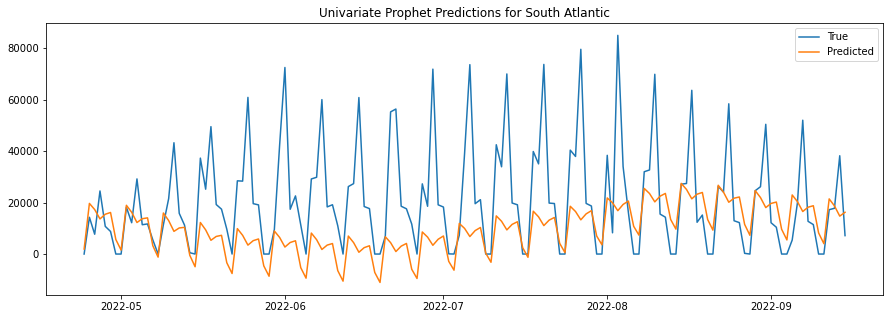


Training model for West North Central...
MAE: 3412.23
MSE: 16740616.26
RMSE: 4091.53
MASE: 1.09


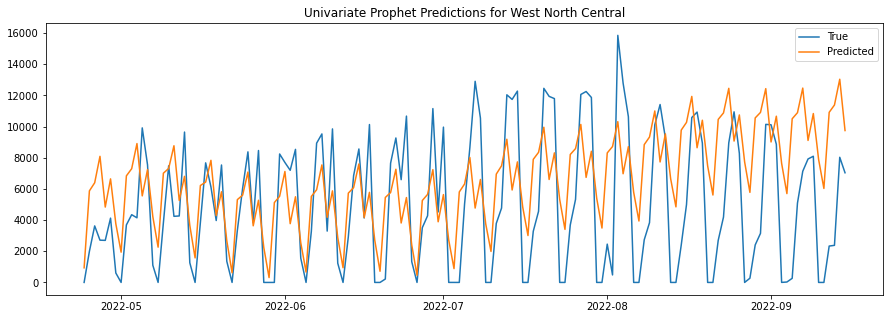


Training model for West South Central...
MAE: 7337.51
MSE: 92715651.8
RMSE: 9628.9
MASE: 1.66


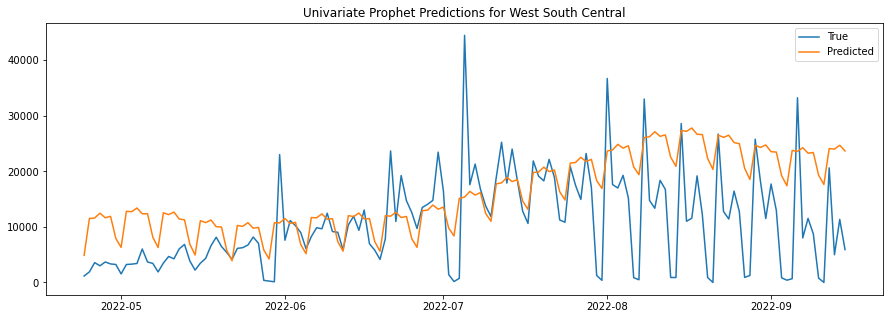


--- 3.02 seconds ---


In [9]:
start_time = time.time()
for df in datasets:
    build_prophet(df, params=parameters[df["region"].iloc[0]], plot=True)
    print("")
print(f"--- {round(time.time() - start_time, 2)} seconds ---")